# PyTorch Experiment Trcking
* Machine Learing is very Experimental

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.4.1
0.19.1


In [3]:
# set device agnostic code 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
#set seeds
def set_seed(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed()

* Let's import the code that we written in the previous section.

In [6]:
from modulers import engine, data_setup

# 1. Get Data
* We want to get some pizza, steak and suchi.

In [7]:
import os
import zipfile
from pathlib import Path

import requests

def download_data(
    source: str,
    destination: str,
    remove_source: bool = True
):
    """Dounload a zipped dataset from source and unzip to destination."""
    data_path = Path("data/")
    image_path = data_path / destination

    if image_path.is_dir():
        print(f"[INFO] {image_path} directory already exists, skiping download..")
    else:
        print(f"[INFO] Did not find {image_path}, creating a new one")
        image_path.mkdir(parents=True, exist_ok=True)
        target_file = Path(source).name
        
        with open(data_path / target_file, "wb") as f:
            respond = requests.get(source)
            print(f"Downloading {target_file}, from {source}...")
            f.write(respond.content)

        with zipfile.ZipFile(data_path / target_file, "r") as zf:
            zf.extractall(image_path)

        if remove_source:
            os.remove(data_path / target_file)
            
    return image_path

In [8]:
target_source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
destination = "pizza_steak_sushi"

image_path = download_data(target_source, destination, remove_source=True)

[INFO] data\pizza_steak_sushi directory already exists, skiping download..


# 2. Create Dataset and DataLoader

### 2.1 Create DataLoaders with manual transformrs


In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [10]:
# Setup imageNet normalization levels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Create transforms pipeline manualy
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

# create dataloader
train_loader, test_loader, class_names = data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=32
)

### 2.2 Create DataLoaders using automatically created transformrs

In [12]:
train_dir = image_path / "train"
test_dir = image_path / "test"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
automated_transform = weights.transforms()

# create dataloader
train_loader, test_loader, class_names = data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automated_transform,
    batch_size=32
)


# 3. Getting a pretrained model, Freeeze the layers and change the classifier head

In [13]:
# Pre-pare the model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
# Freeze the model
for parameter in model.features.parameters():
    parameter.requires_grad = False

In [13]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [14]:
# change the classifier head
classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

model.classifier = classifier

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [16]:
sample = next(iter(train_loader))

In [17]:
sample[0].shape

torch.Size([32, 3, 224, 224])

In [18]:
summary(
    model=model,
    col_names=["input_size",
                "output_size",
                "params_percent",
                "trainable",],
    input_size=[32, 3, 224, 224],
    col_width=20
)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param %              Trainable
EfficientNet                                            [32, 3, 224, 224]    [32, 1000]                --              Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]    [32, 1280, 7, 7]          --              False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]    [32, 32, 112, 112]        --              False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]    [32, 32, 112, 112]     0.02%              False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]   [32, 32, 112, 112]     0.00%              False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]   [32, 32, 112, 112]        --              --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]   [32, 16, 112, 112]        --              Fal

___

# 4. Train a single model and track the results

In [19]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

* To track experiments, we are going to use TensorBoard

In [20]:
# Setup a SSummaryWriter 
writer = SummaryWriter()
writer

In [21]:
from modulers.engine import train_step, test_step
from typing import Tuple, List, Dict

from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device
) -> Dict[str, List[float]]:
    """
    Trains and evaluates the model over a specified number of epochs.

    Args:
        model (torch.nn.Module): The neural network model to train and evaluate.
        train_dataloader (torch.utils.data.DataLoader): DataLoader providing the training data in batches.
        test_dataloader (torch.utils.data.DataLoader): DataLoader providing the test data in batches.
        loss_fn (torch.nn.Module): The loss function used to calculate the error between predictions and targets.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model's parameters.
        epochs (int, optional): The number of epochs to train the model. Defaults to 5.
        device (torch.device, optional): The device (CPU or GPU) on which the computations are performed. Defaults to the global `device`.

    Returns:
        Dict[str, List[float]]: A dictionary containing lists of accuracy and loss values for both the training and test datasets across all epochs:
            - "train_acc" (List[float]): Training accuracy for each epoch.
            - "train_loss" (List[float]): Training loss for each epoch.
            - "test_acc" (List[float]): Test accuracy for each epoch.
            - "test_loss" (List[float]): Test loss for each epoch.

    Example usage:
        results = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs=10, device=device)
    """
#     Result dictionary
    result = {
        "train_acc": [],
        "train_loss": [],
        "test_acc": [],
        "test_loss": [],
    }
#     loop throught train, and test step functions
    for epoch in tqdm(range(epochs)):
        
        train_acc, train_loss = train_step(model, train_dataloader, optimizer, loss_fn, device)
        
        test_acc, test_loss = test_step(model, test_dataloader, loss_fn, device)
        
#         print out the result
        print(
            f"Epoch: {epoch} | Train acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | Test acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}"
        )
    
        result["train_acc"].append(train_acc)
        result["train_loss"].append(train_loss)
        result["test_acc"].append(test_acc)
        result["test_loss"].append(test_loss)

        ###New: Experiment Tracking ###
        writer.add_scalars(
            main_tag="Loss",
            tag_scalar_dict={
                "train_loss": train_loss,
                "test_loss": test_loss,
            },
            global_step=epoch
        )

        writer.add_scalars(
            main_tag="Accuracy",
            tag_scalar_dict={
                "train_acc": train_acc,
                "test_acc": test_acc
            },
            global_step=epoch
        )
        writer.add_graph(
            model=model,
            input_to_model=torch.rand(32, 3, 224, 224).to(device)
        )

    # Close the writer
    writer.close()
    
    ###End New ###
    return result


In [22]:
# train the model
set_seed()

results = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    device=device
)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.0039, Train Loss: 6.4571 | Test acc: 0.0104, Test Loss: 5.7481


  5%|████▏                                                                              | 1/20 [00:07<02:24,  7.63s/it]

Epoch: 1 | Train acc: 0.2539, Train Loss: 4.0821 | Test acc: 0.1761, Test Loss: 3.4111


 10%|████████▎                                                                          | 2/20 [00:12<01:46,  5.92s/it]

Epoch: 2 | Train acc: 0.2695, Train Loss: 2.6582 | Test acc: 0.2907, Test Loss: 2.4417


 15%|████████████▍                                                                      | 3/20 [00:17<01:31,  5.40s/it]

Epoch: 3 | Train acc: 0.3008, Train Loss: 2.0375 | Test acc: 0.3210, Test Loss: 2.1511


 20%|████████████████▌                                                                  | 4/20 [00:21<01:22,  5.17s/it]

Epoch: 4 | Train acc: 0.3984, Train Loss: 1.6924 | Test acc: 0.4129, Test Loss: 1.9812


 25%|████████████████████▊                                                              | 5/20 [00:27<01:17,  5.17s/it]

Epoch: 5 | Train acc: 0.5938, Train Loss: 1.4387 | Test acc: 0.4242, Test Loss: 1.8708


 30%|████████████████████████▉                                                          | 6/20 [00:32<01:11,  5.10s/it]

Epoch: 6 | Train acc: 0.6289, Train Loss: 1.2824 | Test acc: 0.4867, Test Loss: 1.6808


 35%|█████████████████████████████                                                      | 7/20 [00:36<01:05,  5.01s/it]

Epoch: 7 | Train acc: 0.5430, Train Loss: 1.1659 | Test acc: 0.5587, Test Loss: 1.6178


 40%|█████████████████████████████████▏                                                 | 8/20 [00:41<00:58,  4.91s/it]

Epoch: 8 | Train acc: 0.7383, Train Loss: 1.0423 | Test acc: 0.6013, Test Loss: 1.5391


 45%|█████████████████████████████████████▎                                             | 9/20 [00:46<00:54,  4.92s/it]

Epoch: 9 | Train acc: 0.7695, Train Loss: 0.9571 | Test acc: 0.6714, Test Loss: 1.3064


 50%|█████████████████████████████████████████                                         | 10/20 [00:52<00:51,  5.15s/it]

Epoch: 10 | Train acc: 0.6680, Train Loss: 0.9902 | Test acc: 0.7633, Test Loss: 1.1778


 55%|█████████████████████████████████████████████                                     | 11/20 [00:57<00:46,  5.21s/it]

Epoch: 11 | Train acc: 0.7578, Train Loss: 0.9179 | Test acc: 0.7538, Test Loss: 1.0471


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:02<00:42,  5.25s/it]

Epoch: 12 | Train acc: 0.6641, Train Loss: 0.7939 | Test acc: 0.7538, Test Loss: 0.9722


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:08<00:36,  5.28s/it]

Epoch: 13 | Train acc: 0.7422, Train Loss: 0.8418 | Test acc: 0.7737, Test Loss: 1.1140


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:14<00:32,  5.44s/it]

Epoch: 14 | Train acc: 0.7109, Train Loss: 0.8241 | Test acc: 0.7538, Test Loss: 1.1093


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:19<00:27,  5.51s/it]

Epoch: 15 | Train acc: 0.7383, Train Loss: 0.7459 | Test acc: 0.7027, Test Loss: 1.1283


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:25<00:22,  5.60s/it]

Epoch: 16 | Train acc: 0.7188, Train Loss: 0.7173 | Test acc: 0.7027, Test Loss: 1.2198


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:31<00:16,  5.64s/it]

Epoch: 17 | Train acc: 0.7188, Train Loss: 0.7782 | Test acc: 0.7642, Test Loss: 1.1705


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:36<00:11,  5.62s/it]

Epoch: 18 | Train acc: 0.7578, Train Loss: 0.6356 | Test acc: 0.7841, Test Loss: 0.9981


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:42<00:05,  5.55s/it]

Epoch: 19 | Train acc: 0.8984, Train Loss: 0.5579 | Test acc: 0.8153, Test Loss: 0.9027


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:48<00:00,  5.42s/it]


# 5. View our model's results with TensorBoard

In [23]:
# Let's view our experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

#  6. Create a function to prepare a `SummaryWriter()` instance.
* We would like to track:
    * Experiment date/timestamp
    * Experiment Name
    * Model name
    * Extra - is there anything else that should be tracked?
* For example:
    * `runs/YYYY-MM-DD/Experiment_name/model_name/extra`

In [24]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str, model_name: str, extra: str=None):
    """A function to create torch.utils.tensorboard.SummaryWriter() instance tracking to a specific directory."""
    from datetime import datetime
    import os

    timestamp = str(datetime.now().date())

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    return SummaryWriter(log_dir=log_dir)

In [25]:
create_writer("mo3tsm", "inceptionV3")

# 6.1 Update the `train()` function to include a `writer` parameter

In [26]:
# Update train() to use create_writer()
from modulers.engine import train_step, test_step
from typing import Tuple, List, Dict

from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    writer: torch.utils.tensorboard.writer.SummaryWriter
) -> Dict[str, List[float]]:
    """
    Trains and evaluates the model over a specified number of epochs.

    Args:
        model (torch.nn.Module): The neural network model to train and evaluate.
        train_dataloader (torch.utils.data.DataLoader): DataLoader providing the training data in batches.
        test_dataloader (torch.utils.data.DataLoader): DataLoader providing the test data in batches.
        loss_fn (torch.nn.Module): The loss function used to calculate the error between predictions and targets.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model's parameters.
        epochs (int, optional): The number of epochs to train the model. Defaults to 5.
        device (torch.device, optional): The device (CPU or GPU) on which the computations are performed. Defaults to the global `device`.

    Returns:
        Dict[str, List[float]]: A dictionary containing lists of accuracy and loss values for both the training and test datasets across all epochs:
            - "train_acc" (List[float]): Training accuracy for each epoch.
            - "train_loss" (List[float]): Training loss for each epoch.
            - "test_acc" (List[float]): Test accuracy for each epoch.
            - "test_loss" (List[float]): Test loss for each epoch.

    Example usage:
        results = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs=10, device=device)
    """
#     Result dictionary
    result = {
        "train_acc": [],
        "train_loss": [],
        "test_acc": [],
        "test_loss": [],
    }
#     loop throught train, and test step functions
    for epoch in tqdm(range(epochs)):
        
        train_acc, train_loss = train_step(model, train_dataloader, optimizer, loss_fn, device)
        
        test_acc, test_loss = test_step(model, test_dataloader, loss_fn, device)
        
#         print out the result
        print(
            f"Epoch: {epoch} | Train acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | Test acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}"
        )
    
        result["train_acc"].append(train_acc)
        result["train_loss"].append(train_loss)
        result["test_acc"].append(test_acc)
        result["test_loss"].append(test_loss)

        ###New: Experiment Tracking ###
        if writer:
            writer.add_scalars(
                main_tag="Loss",
                tag_scalar_dict={
                    "train_loss": train_loss,
                    "test_loss": test_loss,
                },
                global_step=epoch
            )
    
            writer.add_scalars(
                main_tag="Accuracy",
                tag_scalar_dict={
                    "train_acc": train_acc,
                    "test_acc": test_acc
                },
                global_step=epoch
            )
            writer.add_graph(
                model=model,
                input_to_model=torch.rand(32, 3, 224, 224).to(device)
            )

            # Close the writer
            writer.close()
        else:
            pass
    
    ###End New ###
    return result


# 7 Setting up a Series of modelling experiments

## 7.1 What kind of experiments should you run, what should you test?
    * Change the nymber of epochs
    * Change the number of hidden layers/units
    * Change the amount of data
    * Change the learning rate
    * Try different kinds of data augmentation
    * Choose a different model architecture 

## 7.2 What experiments are we going to run?
We are going to turn three dials:

    * Model size - EffnetB0 vs EffnetB2
    * Dataset Size - 10% of pizza, steak, sushi images vs 20%
    * Training time - 5 epochs vs 10 epochs

## 7.3 Download different dataset
We want two datasets:

    * Pizza, Steak, Sushi 10%
    * Pizza, Steak, Sushi 20%

In [27]:
data_10_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
    remove_source=True
)

[INFO] data\pizza_steak_sushi directory already exists, skiping download..


In [28]:
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent",
    remove_source=True
)

[INFO] data\pizza_steak_sushi_20_percent directory already exists, skiping download..


## 7.4 Transform Datasets and Create DataLoaders
The steps which we will follow to transform our data:

    * Resize the image to (224, 224)
    * Make sure image tensor values are between [0, 1]
    * Normalize the images so they have the same data distibution as ImageNet

In [29]:
# Set up training path directory
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Set up testing path directory
test_dir = data_10_percent_path / "test"

In [30]:
from torchvision import transforms

# Setup imageNet normalization levels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Create transforms pipeline manualy
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

# create 10% training and test dataloader
train_10_percent_dataloader, test_loader, class_names = data_setup.create_dataloader(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=32
)

# create 20% training and test dataloader
train_20_percent_dataloader, test_loader, class_names = data_setup.create_dataloader(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=32
)

## 7.5 Create Feature extractor model

We want two functions:

    1. Create a `torchvision.models.efficientnet_b0()` feature extractor with a frozen backbone/base layers and a custom classifier head
    2. Create a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone/base layers and a custom classifier head

In [31]:
effnet_b2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# prepare the model
effnet_b2 = torchvision.models.efficientnet_b2(weights=effnet_b2_weights)

In [32]:
summary(
    model=effnet_b2,
    col_names=["input_size",
                "output_size",
                "params_percent",
                "trainable",],
    input_size=[32, 3, 224, 224],
    col_width=20
)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param %              Trainable
EfficientNet                                            [32, 3, 224, 224]    [32, 1000]                --              True
├─Sequential: 1-1                                       [32, 3, 224, 224]    [32, 1408, 7, 7]          --              True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]    [32, 32, 112, 112]        --              True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]    [32, 32, 112, 112]     0.01%              True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]   [32, 32, 112, 112]     0.00%              True
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]   [32, 32, 112, 112]        --              --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]   [32, 16, 112, 112]        --              True
│    

In [37]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for params in model.features.parameters():
        params.requires_grad = False

    set_seed()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES, bias=True)
    ).to(device)

    model.name = "effnetb0"
    print(f"[INFO] Created New {model.name} model..")
    return model

In [38]:
created_model_test_effnetb0 = create_effnetb0()

[INFO] Created New effnetb0 model..


In [39]:
def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for params in model.features.parameters():
        params.requires_grad = False

    set_seed()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES, bias=True)
    ).to(device)

    model.name = "effnetb2"
    print(f"[INFO] Created New {model.name} model..")
    return model

In [40]:
created_model_test_effnetb2 = create_effnetb2()

[INFO] Created New effnetb2 model..


## 7.6 Create experiments and set up training code

In [41]:
num_epochs = [20, 30]

models = ["effnetb0", "effnetb2"]

train_dataloaders = {
    "data_10_percent": train_10_percent_dataloader,
    "data_20_percent": train_20_percent_dataloader
}

In [42]:
!nvidia-smi

Thu Nov 28 23:57:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.81                 Driver Version: 560.81         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8              2W /   35W |     781MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [44]:
%%time
from modulers.utils import save_model

set_seed(42)

experiment_number = 0

for data_loadername, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            experiment_number += 1

            print(f"[INFO] Experiment Number: {experiment_number}")
            print(f"[INFO] Model Name: {model_name}")
            print(f"[INFO] DataLoader: {data_loadername}")
            print(f"[INFO] Number of Epochs: {epochs}")

            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()

            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.003)

            train(
                model=model,
                train_dataloader=train_dataloader,
                test_dataloader= test_loader,
                loss_fn= loss_fn,
                optimizer= optimizer,
                epochs= epochs,
                device= device,
                writer= create_writer(
                    experiment_name=data_loadername,
                    extra=f"{epochs}_epochs",
                    model_name=model_name,
                ), 
            )

            save_filepath = f"09_{model_name}_{data_loadername}_{epochs}_epochs.pth"
            save_model(
                model=model,
                target_dir="models",
                model_name=save_filepath
            )
            
            print("_" * 50 + "\n")

[INFO] Experiment Number: 1
[INFO] Model Name: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 20
[INFO] Created New effnetb0 model..


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.5469, Train Loss: 1.0064 | Test acc: 0.7538, Test Loss: 0.6809


  5%|████▏                                                                              | 1/20 [00:04<01:32,  4.87s/it]

Epoch: 1 | Train acc: 0.7109, Train Loss: 0.6850 | Test acc: 0.8362, Test Loss: 0.5335


 10%|████████▎                                                                          | 2/20 [00:09<01:24,  4.69s/it]

Epoch: 2 | Train acc: 0.7695, Train Loss: 0.5819 | Test acc: 0.8759, Test Loss: 0.4185


 15%|████████████▍                                                                      | 3/20 [00:13<01:17,  4.56s/it]

Epoch: 3 | Train acc: 0.7539, Train Loss: 0.4995 | Test acc: 0.8759, Test Loss: 0.3550


 20%|████████████████▌                                                                  | 4/20 [00:18<01:12,  4.52s/it]

Epoch: 4 | Train acc: 0.8906, Train Loss: 0.3482 | Test acc: 0.8665, Test Loss: 0.5019


 25%|████████████████████▊                                                              | 5/20 [00:22<01:07,  4.49s/it]

Epoch: 5 | Train acc: 0.8906, Train Loss: 0.3564 | Test acc: 0.8977, Test Loss: 0.4031


 30%|████████████████████████▉                                                          | 6/20 [00:27<01:04,  4.57s/it]

Epoch: 6 | Train acc: 0.8320, Train Loss: 0.3609 | Test acc: 0.9176, Test Loss: 0.3494


 35%|█████████████████████████████                                                      | 7/20 [00:32<01:00,  4.64s/it]

Epoch: 7 | Train acc: 0.9609, Train Loss: 0.2532 | Test acc: 0.8456, Test Loss: 0.3959


 40%|█████████████████████████████████▏                                                 | 8/20 [00:37<00:56,  4.71s/it]

Epoch: 8 | Train acc: 0.9180, Train Loss: 0.3100 | Test acc: 0.9072, Test Loss: 0.3721


 45%|█████████████████████████████████████▎                                             | 9/20 [00:42<00:52,  4.80s/it]

Epoch: 9 | Train acc: 0.8203, Train Loss: 0.3507 | Test acc: 0.9072, Test Loss: 0.3055


 50%|█████████████████████████████████████████                                         | 10/20 [00:46<00:48,  4.82s/it]

Epoch: 10 | Train acc: 0.9570, Train Loss: 0.1979 | Test acc: 0.9072, Test Loss: 0.3747


 55%|█████████████████████████████████████████████                                     | 11/20 [00:52<00:44,  4.91s/it]

Epoch: 11 | Train acc: 0.7969, Train Loss: 0.5003 | Test acc: 0.9072, Test Loss: 0.3409


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:57<00:39,  4.96s/it]

Epoch: 12 | Train acc: 0.8398, Train Loss: 0.3479 | Test acc: 0.9072, Test Loss: 0.3043


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:02<00:34,  4.98s/it]

Epoch: 13 | Train acc: 0.9414, Train Loss: 0.2750 | Test acc: 0.8551, Test Loss: 0.2673


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:07<00:30,  5.02s/it]

Epoch: 14 | Train acc: 0.9531, Train Loss: 0.2155 | Test acc: 0.9176, Test Loss: 0.3122


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:13<00:27,  5.46s/it]

Epoch: 15 | Train acc: 0.8477, Train Loss: 0.2647 | Test acc: 0.9176, Test Loss: 0.3305


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:19<00:22,  5.64s/it]

Epoch: 16 | Train acc: 0.9609, Train Loss: 0.1590 | Test acc: 0.8873, Test Loss: 0.3609


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:24<00:16,  5.47s/it]

Epoch: 17 | Train acc: 0.8477, Train Loss: 0.3420 | Test acc: 0.9176, Test Loss: 0.2897


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:29<00:10,  5.32s/it]

Epoch: 18 | Train acc: 0.9805, Train Loss: 0.1494 | Test acc: 0.9072, Test Loss: 0.2704


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:35<00:05,  5.33s/it]

Epoch: 19 | Train acc: 0.8242, Train Loss: 0.4427 | Test acc: 0.9072, Test Loss: 0.2727


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:40<00:00,  5.01s/it]


The model was saved successfully in: models\09_effnetb0_data_10_percent_20_epochs.pth
__________________________________________________

[INFO] Experiment Number: 2
[INFO] Model Name: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 20
[INFO] Created New effnetb2 model..


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.4805, Train Loss: 0.9995 | Test acc: 0.6420, Test Loss: 0.8763


  5%|████▏                                                                              | 1/20 [00:06<01:59,  6.30s/it]

Epoch: 1 | Train acc: 0.8242, Train Loss: 0.6309 | Test acc: 0.8769, Test Loss: 0.6050


 10%|████████▎                                                                          | 2/20 [00:12<01:57,  6.53s/it]

Epoch: 2 | Train acc: 0.7656, Train Loss: 0.5168 | Test acc: 0.9280, Test Loss: 0.4848


 15%|████████████▍                                                                      | 3/20 [00:19<01:48,  6.38s/it]

Epoch: 3 | Train acc: 0.8906, Train Loss: 0.4313 | Test acc: 0.8864, Test Loss: 0.4624


 20%|████████████████▌                                                                  | 4/20 [00:25<01:40,  6.31s/it]

Epoch: 4 | Train acc: 0.8047, Train Loss: 0.4663 | Test acc: 0.8362, Test Loss: 0.4606


 25%|████████████████████▊                                                              | 5/20 [00:31<01:35,  6.38s/it]

Epoch: 5 | Train acc: 0.8359, Train Loss: 0.4073 | Test acc: 0.8466, Test Loss: 0.5188


 30%|████████████████████████▉                                                          | 6/20 [00:38<01:30,  6.48s/it]

Epoch: 6 | Train acc: 0.8203, Train Loss: 0.5078 | Test acc: 0.9081, Test Loss: 0.3898


 35%|█████████████████████████████                                                      | 7/20 [00:44<01:23,  6.39s/it]

Epoch: 7 | Train acc: 0.8164, Train Loss: 0.3682 | Test acc: 0.8362, Test Loss: 0.4565


 40%|█████████████████████████████████▏                                                 | 8/20 [00:50<01:15,  6.32s/it]

Epoch: 8 | Train acc: 0.8164, Train Loss: 0.3692 | Test acc: 0.8977, Test Loss: 0.3867


 45%|█████████████████████████████████████▎                                             | 9/20 [00:57<01:10,  6.38s/it]

Epoch: 9 | Train acc: 0.8359, Train Loss: 0.3338 | Test acc: 0.8977, Test Loss: 0.3980


 50%|█████████████████████████████████████████                                         | 10/20 [01:03<01:04,  6.41s/it]

Epoch: 10 | Train acc: 0.9336, Train Loss: 0.2749 | Test acc: 0.8362, Test Loss: 0.4395


 55%|█████████████████████████████████████████████                                     | 11/20 [01:10<00:57,  6.34s/it]

Epoch: 11 | Train acc: 0.9258, Train Loss: 0.2512 | Test acc: 0.8977, Test Loss: 0.3890


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:16<00:50,  6.32s/it]

Epoch: 12 | Train acc: 0.8438, Train Loss: 0.3178 | Test acc: 0.8977, Test Loss: 0.3743


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:22<00:44,  6.33s/it]

Epoch: 13 | Train acc: 0.8477, Train Loss: 0.3660 | Test acc: 0.8466, Test Loss: 0.4425


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:29<00:37,  6.31s/it]

Epoch: 14 | Train acc: 0.9609, Train Loss: 0.2454 | Test acc: 0.8968, Test Loss: 0.3530


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:35<00:31,  6.32s/it]

Epoch: 15 | Train acc: 0.7773, Train Loss: 0.5372 | Test acc: 0.8968, Test Loss: 0.3275


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:41<00:25,  6.34s/it]

Epoch: 16 | Train acc: 0.8438, Train Loss: 0.3935 | Test acc: 0.8267, Test Loss: 0.4234


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:48<00:19,  6.41s/it]

Epoch: 17 | Train acc: 0.8320, Train Loss: 0.4865 | Test acc: 0.8059, Test Loss: 0.4731


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:54<00:12,  6.48s/it]

Epoch: 18 | Train acc: 0.8398, Train Loss: 0.3693 | Test acc: 0.9280, Test Loss: 0.3345


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:01<00:06,  6.52s/it]

Epoch: 19 | Train acc: 0.9844, Train Loss: 0.2036 | Test acc: 0.8977, Test Loss: 0.3558


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:07<00:00,  6.40s/it]


The model was saved successfully in: models\09_effnetb2_data_10_percent_20_epochs.pth
__________________________________________________

[INFO] Experiment Number: 3
[INFO] Model Name: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 30
[INFO] Created New effnetb0 model..


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.5469, Train Loss: 1.0064 | Test acc: 0.7538, Test Loss: 0.6809


  3%|██▊                                                                                | 1/30 [00:05<02:25,  5.03s/it]

Epoch: 1 | Train acc: 0.7109, Train Loss: 0.6850 | Test acc: 0.8362, Test Loss: 0.5335


  7%|█████▌                                                                             | 2/30 [00:10<02:35,  5.55s/it]

Epoch: 2 | Train acc: 0.7695, Train Loss: 0.5819 | Test acc: 0.8759, Test Loss: 0.4185


 10%|████████▎                                                                          | 3/30 [00:16<02:35,  5.75s/it]

Epoch: 3 | Train acc: 0.7539, Train Loss: 0.4995 | Test acc: 0.8759, Test Loss: 0.3550


 13%|███████████                                                                        | 4/30 [00:22<02:27,  5.67s/it]

Epoch: 4 | Train acc: 0.8906, Train Loss: 0.3482 | Test acc: 0.8665, Test Loss: 0.5019


 17%|█████████████▊                                                                     | 5/30 [00:28<02:23,  5.74s/it]

Epoch: 5 | Train acc: 0.8906, Train Loss: 0.3564 | Test acc: 0.8977, Test Loss: 0.4031


 20%|████████████████▌                                                                  | 6/30 [00:34<02:17,  5.73s/it]

Epoch: 6 | Train acc: 0.8320, Train Loss: 0.3609 | Test acc: 0.9176, Test Loss: 0.3494


 23%|███████████████████▎                                                               | 7/30 [00:40<02:13,  5.81s/it]

Epoch: 7 | Train acc: 0.9609, Train Loss: 0.2532 | Test acc: 0.8456, Test Loss: 0.3959


 27%|██████████████████████▏                                                            | 8/30 [00:45<02:08,  5.83s/it]

Epoch: 8 | Train acc: 0.9180, Train Loss: 0.3100 | Test acc: 0.9072, Test Loss: 0.3721


 30%|████████████████████████▉                                                          | 9/30 [00:51<02:00,  5.74s/it]

Epoch: 9 | Train acc: 0.8203, Train Loss: 0.3507 | Test acc: 0.9072, Test Loss: 0.3055


 33%|███████████████████████████▎                                                      | 10/30 [00:57<01:54,  5.73s/it]

Epoch: 10 | Train acc: 0.9570, Train Loss: 0.1979 | Test acc: 0.9072, Test Loss: 0.3747


 37%|██████████████████████████████                                                    | 11/30 [01:02<01:49,  5.74s/it]

Epoch: 11 | Train acc: 0.7969, Train Loss: 0.5003 | Test acc: 0.9072, Test Loss: 0.3409


 40%|████████████████████████████████▊                                                 | 12/30 [01:08<01:44,  5.80s/it]

Epoch: 12 | Train acc: 0.8398, Train Loss: 0.3479 | Test acc: 0.9072, Test Loss: 0.3043


 43%|███████████████████████████████████▌                                              | 13/30 [01:14<01:38,  5.82s/it]

Epoch: 13 | Train acc: 0.9414, Train Loss: 0.2750 | Test acc: 0.8551, Test Loss: 0.2673


 47%|██████████████████████████████████████▎                                           | 14/30 [01:20<01:32,  5.75s/it]

Epoch: 14 | Train acc: 0.9531, Train Loss: 0.2155 | Test acc: 0.9176, Test Loss: 0.3122


 50%|█████████████████████████████████████████                                         | 15/30 [01:26<01:26,  5.75s/it]

Epoch: 15 | Train acc: 0.8477, Train Loss: 0.2647 | Test acc: 0.9176, Test Loss: 0.3305


 53%|███████████████████████████████████████████▋                                      | 16/30 [01:31<01:20,  5.73s/it]

Epoch: 16 | Train acc: 0.9609, Train Loss: 0.1590 | Test acc: 0.8873, Test Loss: 0.3609


 57%|██████████████████████████████████████████████▍                                   | 17/30 [01:37<01:14,  5.73s/it]

Epoch: 17 | Train acc: 0.8477, Train Loss: 0.3420 | Test acc: 0.9176, Test Loss: 0.2897


 60%|█████████████████████████████████████████████████▏                                | 18/30 [01:43<01:09,  5.81s/it]

Epoch: 18 | Train acc: 0.9805, Train Loss: 0.1494 | Test acc: 0.9072, Test Loss: 0.2704


 63%|███████████████████████████████████████████████████▉                              | 19/30 [01:49<01:03,  5.78s/it]

Epoch: 19 | Train acc: 0.8242, Train Loss: 0.4427 | Test acc: 0.9072, Test Loss: 0.2727


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [01:54<00:57,  5.75s/it]

Epoch: 20 | Train acc: 0.8555, Train Loss: 0.2936 | Test acc: 0.9072, Test Loss: 0.3567


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [02:00<00:51,  5.70s/it]

Epoch: 21 | Train acc: 0.8477, Train Loss: 0.2789 | Test acc: 0.9072, Test Loss: 0.2687


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [02:06<00:45,  5.71s/it]

Epoch: 22 | Train acc: 0.7773, Train Loss: 0.4647 | Test acc: 0.8655, Test Loss: 0.2742


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [02:11<00:39,  5.68s/it]

Epoch: 23 | Train acc: 0.8477, Train Loss: 0.3340 | Test acc: 0.9384, Test Loss: 0.3229


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [02:17<00:34,  5.71s/it]

Epoch: 24 | Train acc: 0.9883, Train Loss: 0.1808 | Test acc: 0.9280, Test Loss: 0.2419


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [02:23<00:28,  5.66s/it]

Epoch: 25 | Train acc: 0.8672, Train Loss: 0.3121 | Test acc: 0.9384, Test Loss: 0.3012


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [02:28<00:22,  5.63s/it]

Epoch: 26 | Train acc: 0.8711, Train Loss: 0.3087 | Test acc: 0.9072, Test Loss: 0.2520


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [02:34<00:16,  5.61s/it]

Epoch: 27 | Train acc: 0.8594, Train Loss: 0.2010 | Test acc: 0.9280, Test Loss: 0.2288


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [02:39<00:11,  5.62s/it]

Epoch: 28 | Train acc: 0.8633, Train Loss: 0.3397 | Test acc: 0.9280, Test Loss: 0.2225


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [02:45<00:05,  5.57s/it]

Epoch: 29 | Train acc: 0.8633, Train Loss: 0.2604 | Test acc: 0.9384, Test Loss: 0.3385


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:51<00:00,  5.71s/it]


The model was saved successfully in: models\09_effnetb0_data_10_percent_30_epochs.pth
__________________________________________________

[INFO] Experiment Number: 4
[INFO] Model Name: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 30
[INFO] Created New effnetb2 model..


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.4805, Train Loss: 0.9995 | Test acc: 0.6420, Test Loss: 0.8763


  3%|██▊                                                                                | 1/30 [00:07<03:25,  7.08s/it]

Epoch: 1 | Train acc: 0.8242, Train Loss: 0.6309 | Test acc: 0.8769, Test Loss: 0.6050


  7%|█████▌                                                                             | 2/30 [00:14<03:16,  7.00s/it]

Epoch: 2 | Train acc: 0.7656, Train Loss: 0.5168 | Test acc: 0.9280, Test Loss: 0.4848


 10%|████████▎                                                                          | 3/30 [00:21<03:08,  6.99s/it]

Epoch: 3 | Train acc: 0.8906, Train Loss: 0.4313 | Test acc: 0.8864, Test Loss: 0.4624


 13%|███████████                                                                        | 4/30 [00:28<03:02,  7.03s/it]

Epoch: 4 | Train acc: 0.8047, Train Loss: 0.4663 | Test acc: 0.8362, Test Loss: 0.4606


 17%|█████████████▊                                                                     | 5/30 [00:35<02:56,  7.06s/it]

Epoch: 5 | Train acc: 0.8359, Train Loss: 0.4073 | Test acc: 0.8466, Test Loss: 0.5188


 20%|████████████████▌                                                                  | 6/30 [00:42<02:51,  7.13s/it]

Epoch: 6 | Train acc: 0.8203, Train Loss: 0.5078 | Test acc: 0.9081, Test Loss: 0.3898


 23%|███████████████████▎                                                               | 7/30 [00:49<02:41,  7.04s/it]

Epoch: 7 | Train acc: 0.8164, Train Loss: 0.3682 | Test acc: 0.8362, Test Loss: 0.4565


 27%|██████████████████████▏                                                            | 8/30 [00:56<02:34,  7.04s/it]

Epoch: 8 | Train acc: 0.8164, Train Loss: 0.3692 | Test acc: 0.8977, Test Loss: 0.3867


 30%|████████████████████████▉                                                          | 9/30 [01:03<02:28,  7.05s/it]

Epoch: 9 | Train acc: 0.8359, Train Loss: 0.3338 | Test acc: 0.8977, Test Loss: 0.3980


 33%|███████████████████████████▎                                                      | 10/30 [01:10<02:22,  7.13s/it]

Epoch: 10 | Train acc: 0.9336, Train Loss: 0.2749 | Test acc: 0.8362, Test Loss: 0.4395


 37%|██████████████████████████████                                                    | 11/30 [01:17<02:15,  7.13s/it]

Epoch: 11 | Train acc: 0.9258, Train Loss: 0.2512 | Test acc: 0.8977, Test Loss: 0.3890


 40%|████████████████████████████████▊                                                 | 12/30 [01:24<02:07,  7.07s/it]

Epoch: 12 | Train acc: 0.8438, Train Loss: 0.3178 | Test acc: 0.8977, Test Loss: 0.3743


 43%|███████████████████████████████████▌                                              | 13/30 [01:31<01:58,  6.97s/it]

Epoch: 13 | Train acc: 0.8477, Train Loss: 0.3660 | Test acc: 0.8466, Test Loss: 0.4425


 47%|██████████████████████████████████████▎                                           | 14/30 [01:38<01:50,  6.93s/it]

Epoch: 14 | Train acc: 0.9609, Train Loss: 0.2454 | Test acc: 0.8968, Test Loss: 0.3530


 50%|█████████████████████████████████████████                                         | 15/30 [01:45<01:44,  6.94s/it]

Epoch: 15 | Train acc: 0.7773, Train Loss: 0.5372 | Test acc: 0.8968, Test Loss: 0.3275


 53%|███████████████████████████████████████████▋                                      | 16/30 [01:52<01:38,  7.03s/it]

Epoch: 16 | Train acc: 0.8438, Train Loss: 0.3935 | Test acc: 0.8267, Test Loss: 0.4234


 57%|██████████████████████████████████████████████▍                                   | 17/30 [01:59<01:31,  7.03s/it]

Epoch: 17 | Train acc: 0.8320, Train Loss: 0.4865 | Test acc: 0.8059, Test Loss: 0.4731


 60%|█████████████████████████████████████████████████▏                                | 18/30 [02:06<01:24,  7.06s/it]

Epoch: 18 | Train acc: 0.8398, Train Loss: 0.3693 | Test acc: 0.9280, Test Loss: 0.3345


 63%|███████████████████████████████████████████████████▉                              | 19/30 [02:14<01:18,  7.13s/it]

Epoch: 19 | Train acc: 0.9844, Train Loss: 0.2036 | Test acc: 0.8977, Test Loss: 0.3558


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [02:22<01:15,  7.56s/it]

Epoch: 20 | Train acc: 0.8477, Train Loss: 0.3208 | Test acc: 0.8163, Test Loss: 0.4587


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [02:30<01:07,  7.55s/it]

Epoch: 21 | Train acc: 0.8398, Train Loss: 0.4303 | Test acc: 0.9176, Test Loss: 0.3061


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [02:37<00:59,  7.42s/it]

Epoch: 22 | Train acc: 0.8477, Train Loss: 0.2128 | Test acc: 0.8873, Test Loss: 0.3268


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [02:44<00:51,  7.32s/it]

Epoch: 23 | Train acc: 0.8555, Train Loss: 0.3299 | Test acc: 0.8769, Test Loss: 0.3124


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [02:51<00:43,  7.19s/it]

Epoch: 24 | Train acc: 0.8555, Train Loss: 0.2700 | Test acc: 0.8570, Test Loss: 0.3783


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [02:58<00:36,  7.28s/it]

Epoch: 25 | Train acc: 0.9727, Train Loss: 0.1786 | Test acc: 0.9384, Test Loss: 0.2939


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [03:05<00:29,  7.28s/it]

Epoch: 26 | Train acc: 0.9570, Train Loss: 0.1671 | Test acc: 0.9375, Test Loss: 0.2806


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [03:13<00:21,  7.22s/it]

Epoch: 27 | Train acc: 0.8398, Train Loss: 0.4208 | Test acc: 0.9176, Test Loss: 0.2833


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [03:20<00:14,  7.27s/it]

Epoch: 28 | Train acc: 0.8594, Train Loss: 0.2564 | Test acc: 0.8873, Test Loss: 0.3529


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [03:28<00:07,  7.39s/it]

Epoch: 29 | Train acc: 0.8438, Train Loss: 0.2331 | Test acc: 0.7746, Test Loss: 0.4791


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:35<00:00,  7.18s/it]


The model was saved successfully in: models\09_effnetb2_data_10_percent_30_epochs.pth
__________________________________________________

[INFO] Experiment Number: 5
[INFO] Model Name: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of Epochs: 20
[INFO] Created New effnetb0 model..


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.7146, Train Loss: 0.7806 | Test acc: 0.9072, Test Loss: 0.3901


  5%|████▏                                                                              | 1/20 [00:14<04:27, 14.08s/it]

Epoch: 1 | Train acc: 0.8187, Train Loss: 0.4550 | Test acc: 0.9280, Test Loss: 0.3053


 10%|████████▎                                                                          | 2/20 [00:22<03:17, 11.00s/it]

Epoch: 2 | Train acc: 0.8896, Train Loss: 0.3690 | Test acc: 0.9384, Test Loss: 0.2566


 15%|████████████▍                                                                      | 3/20 [00:31<02:45,  9.74s/it]

Epoch: 3 | Train acc: 0.9146, Train Loss: 0.2760 | Test acc: 0.9384, Test Loss: 0.2598


 20%|████████████████▌                                                                  | 4/20 [00:39<02:25,  9.11s/it]

Epoch: 4 | Train acc: 0.8646, Train Loss: 0.3154 | Test acc: 0.9384, Test Loss: 0.2402


 25%|████████████████████▊                                                              | 5/20 [00:47<02:12,  8.85s/it]

Epoch: 5 | Train acc: 0.9167, Train Loss: 0.2677 | Test acc: 0.9384, Test Loss: 0.2559


 30%|████████████████████████▉                                                          | 6/20 [00:56<02:01,  8.66s/it]

Epoch: 6 | Train acc: 0.8833, Train Loss: 0.2655 | Test acc: 0.9384, Test Loss: 0.2591


 35%|█████████████████████████████                                                      | 7/20 [01:04<01:53,  8.72s/it]

Epoch: 7 | Train acc: 0.9167, Train Loss: 0.2254 | Test acc: 0.9384, Test Loss: 0.2841


 40%|█████████████████████████████████▏                                                 | 8/20 [01:13<01:43,  8.61s/it]

Epoch: 8 | Train acc: 0.9208, Train Loss: 0.2785 | Test acc: 0.9384, Test Loss: 0.2856


 45%|█████████████████████████████████████▎                                             | 9/20 [01:21<01:34,  8.59s/it]

Epoch: 9 | Train acc: 0.9000, Train Loss: 0.2831 | Test acc: 0.9176, Test Loss: 0.2602


 50%|█████████████████████████████████████████                                         | 10/20 [01:30<01:24,  8.49s/it]

Epoch: 10 | Train acc: 0.8812, Train Loss: 0.3270 | Test acc: 0.9280, Test Loss: 0.2246


 55%|█████████████████████████████████████████████                                     | 11/20 [01:38<01:15,  8.38s/it]

Epoch: 11 | Train acc: 0.9000, Train Loss: 0.2317 | Test acc: 0.9072, Test Loss: 0.2073


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:46<01:07,  8.43s/it]

Epoch: 12 | Train acc: 0.9542, Train Loss: 0.1637 | Test acc: 0.9186, Test Loss: 0.2896


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:54<00:58,  8.38s/it]

Epoch: 13 | Train acc: 0.9708, Train Loss: 0.1254 | Test acc: 0.9176, Test Loss: 0.1915


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:03<00:50,  8.40s/it]

Epoch: 14 | Train acc: 0.9354, Train Loss: 0.1755 | Test acc: 0.9280, Test Loss: 0.2354


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:12<00:42,  8.51s/it]

Epoch: 15 | Train acc: 0.9396, Train Loss: 0.1968 | Test acc: 0.9280, Test Loss: 0.2385


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [02:20<00:33,  8.41s/it]

Epoch: 16 | Train acc: 0.9542, Train Loss: 0.1565 | Test acc: 0.9280, Test Loss: 0.1931


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [02:28<00:25,  8.34s/it]

Epoch: 17 | Train acc: 0.9875, Train Loss: 0.1058 | Test acc: 0.9186, Test Loss: 0.2655


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [02:37<00:16,  8.39s/it]

Epoch: 18 | Train acc: 0.9042, Train Loss: 0.1829 | Test acc: 0.8977, Test Loss: 0.2231


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:45<00:08,  8.43s/it]

Epoch: 19 | Train acc: 0.9167, Train Loss: 0.1681 | Test acc: 0.9176, Test Loss: 0.2369


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:53<00:00,  8.69s/it]


The model was saved successfully in: models\09_effnetb0_data_20_percent_20_epochs.pth
__________________________________________________

[INFO] Experiment Number: 6
[INFO] Model Name: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of Epochs: 20
[INFO] Created New effnetb2 model..


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.6750, Train Loss: 0.8323 | Test acc: 0.8778, Test Loss: 0.5078


  5%|████▏                                                                              | 1/20 [00:10<03:10, 10.02s/it]

Epoch: 1 | Train acc: 0.8875, Train Loss: 0.4077 | Test acc: 0.9176, Test Loss: 0.3837


 10%|████████▎                                                                          | 2/20 [00:19<02:59,  9.95s/it]

Epoch: 2 | Train acc: 0.9146, Train Loss: 0.3330 | Test acc: 0.8674, Test Loss: 0.4045


 15%|████████████▍                                                                      | 3/20 [00:29<02:49,  9.95s/it]

Epoch: 3 | Train acc: 0.8812, Train Loss: 0.3437 | Test acc: 0.9384, Test Loss: 0.3605


 20%|████████████████▌                                                                  | 4/20 [00:39<02:38,  9.93s/it]

Epoch: 4 | Train acc: 0.8896, Train Loss: 0.2883 | Test acc: 0.9081, Test Loss: 0.3437


 25%|████████████████████▊                                                              | 5/20 [00:50<02:33, 10.24s/it]

Epoch: 5 | Train acc: 0.9208, Train Loss: 0.2404 | Test acc: 0.9280, Test Loss: 0.3260


 30%|████████████████████████▉                                                          | 6/20 [01:01<02:25, 10.38s/it]

Epoch: 6 | Train acc: 0.9187, Train Loss: 0.2237 | Test acc: 0.8977, Test Loss: 0.3459


 35%|█████████████████████████████                                                      | 7/20 [01:11<02:13, 10.27s/it]

Epoch: 7 | Train acc: 0.9208, Train Loss: 0.2018 | Test acc: 0.8873, Test Loss: 0.3614


 40%|█████████████████████████████████▏                                                 | 8/20 [01:21<02:02, 10.25s/it]

Epoch: 8 | Train acc: 0.9354, Train Loss: 0.2215 | Test acc: 0.8570, Test Loss: 0.3473


 45%|█████████████████████████████████████▎                                             | 9/20 [01:31<01:51, 10.15s/it]

Epoch: 9 | Train acc: 0.9021, Train Loss: 0.2977 | Test acc: 0.8873, Test Loss: 0.3570


 50%|█████████████████████████████████████████                                         | 10/20 [01:41<01:42, 10.28s/it]

Epoch: 10 | Train acc: 0.9437, Train Loss: 0.1815 | Test acc: 0.8665, Test Loss: 0.3456


 55%|█████████████████████████████████████████████                                     | 11/20 [01:53<01:35, 10.66s/it]

Epoch: 11 | Train acc: 0.9646, Train Loss: 0.1558 | Test acc: 0.8977, Test Loss: 0.3204


 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:05<01:27, 10.98s/it]

Epoch: 12 | Train acc: 0.9333, Train Loss: 0.1886 | Test acc: 0.8466, Test Loss: 0.3659


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:18<01:21, 11.70s/it]

Epoch: 13 | Train acc: 0.9167, Train Loss: 0.1743 | Test acc: 0.9176, Test Loss: 0.3047


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:32<01:14, 12.39s/it]

Epoch: 14 | Train acc: 0.9542, Train Loss: 0.1772 | Test acc: 0.8267, Test Loss: 0.3659


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:45<01:02, 12.56s/it]

Epoch: 15 | Train acc: 0.8896, Train Loss: 0.2544 | Test acc: 0.8769, Test Loss: 0.3420


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [02:57<00:49, 12.27s/it]

Epoch: 16 | Train acc: 0.9021, Train Loss: 0.3757 | Test acc: 0.8466, Test Loss: 0.3711


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:09<00:36, 12.29s/it]

Epoch: 17 | Train acc: 0.9042, Train Loss: 0.2288 | Test acc: 0.8059, Test Loss: 0.4554


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [03:25<00:27, 13.56s/it]

Epoch: 18 | Train acc: 0.9187, Train Loss: 0.2874 | Test acc: 0.8570, Test Loss: 0.3741


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:36<00:12, 12.76s/it]

Epoch: 19 | Train acc: 0.9104, Train Loss: 0.2231 | Test acc: 0.8059, Test Loss: 0.4858


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:47<00:00, 11.39s/it]


The model was saved successfully in: models\09_effnetb2_data_20_percent_20_epochs.pth
__________________________________________________

[INFO] Experiment Number: 7
[INFO] Model Name: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of Epochs: 30
[INFO] Created New effnetb0 model..


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.7146, Train Loss: 0.7806 | Test acc: 0.9072, Test Loss: 0.3901


  3%|██▊                                                                                | 1/30 [00:09<04:40,  9.66s/it]

Epoch: 1 | Train acc: 0.8187, Train Loss: 0.4550 | Test acc: 0.9280, Test Loss: 0.3053


  7%|█████▌                                                                             | 2/30 [00:19<04:25,  9.48s/it]

Epoch: 2 | Train acc: 0.8896, Train Loss: 0.3690 | Test acc: 0.9384, Test Loss: 0.2566


 10%|████████▎                                                                          | 3/30 [00:28<04:12,  9.35s/it]

Epoch: 3 | Train acc: 0.9146, Train Loss: 0.2760 | Test acc: 0.9384, Test Loss: 0.2598


 13%|███████████                                                                        | 4/30 [00:37<04:04,  9.39s/it]

Epoch: 4 | Train acc: 0.8646, Train Loss: 0.3154 | Test acc: 0.9384, Test Loss: 0.2402


 17%|█████████████▊                                                                     | 5/30 [00:47<03:56,  9.45s/it]

Epoch: 5 | Train acc: 0.9167, Train Loss: 0.2677 | Test acc: 0.9384, Test Loss: 0.2559


 20%|████████████████▌                                                                  | 6/30 [00:56<03:45,  9.39s/it]

Epoch: 6 | Train acc: 0.8833, Train Loss: 0.2655 | Test acc: 0.9384, Test Loss: 0.2591


 23%|███████████████████▎                                                               | 7/30 [01:05<03:33,  9.28s/it]

Epoch: 7 | Train acc: 0.9167, Train Loss: 0.2254 | Test acc: 0.9384, Test Loss: 0.2841


 27%|██████████████████████▏                                                            | 8/30 [01:14<03:23,  9.26s/it]

Epoch: 8 | Train acc: 0.9208, Train Loss: 0.2785 | Test acc: 0.9384, Test Loss: 0.2856


 30%|████████████████████████▉                                                          | 9/30 [01:23<03:14,  9.24s/it]

Epoch: 9 | Train acc: 0.9000, Train Loss: 0.2831 | Test acc: 0.9176, Test Loss: 0.2602


 33%|███████████████████████████▎                                                      | 10/30 [01:32<03:03,  9.17s/it]

Epoch: 10 | Train acc: 0.8812, Train Loss: 0.3270 | Test acc: 0.9280, Test Loss: 0.2246


 37%|██████████████████████████████                                                    | 11/30 [01:41<02:52,  9.09s/it]

Epoch: 11 | Train acc: 0.9000, Train Loss: 0.2317 | Test acc: 0.9072, Test Loss: 0.2073


 40%|████████████████████████████████▊                                                 | 12/30 [01:51<02:44,  9.15s/it]

Epoch: 12 | Train acc: 0.9542, Train Loss: 0.1637 | Test acc: 0.9186, Test Loss: 0.2896


 43%|███████████████████████████████████▌                                              | 13/30 [02:01<02:40,  9.45s/it]

Epoch: 13 | Train acc: 0.9708, Train Loss: 0.1254 | Test acc: 0.9176, Test Loss: 0.1915


 47%|██████████████████████████████████████▎                                           | 14/30 [02:13<02:46, 10.42s/it]

Epoch: 14 | Train acc: 0.9354, Train Loss: 0.1755 | Test acc: 0.9280, Test Loss: 0.2354


 50%|█████████████████████████████████████████                                         | 15/30 [02:25<02:41, 10.79s/it]

Epoch: 15 | Train acc: 0.9396, Train Loss: 0.1968 | Test acc: 0.9280, Test Loss: 0.2385


 53%|███████████████████████████████████████████▋                                      | 16/30 [02:37<02:34, 11.06s/it]

Epoch: 16 | Train acc: 0.9542, Train Loss: 0.1565 | Test acc: 0.9280, Test Loss: 0.1931


 57%|██████████████████████████████████████████████▍                                   | 17/30 [02:49<02:29, 11.50s/it]

Epoch: 17 | Train acc: 0.9875, Train Loss: 0.1058 | Test acc: 0.9186, Test Loss: 0.2655


 60%|█████████████████████████████████████████████████▏                                | 18/30 [03:00<02:16, 11.36s/it]

Epoch: 18 | Train acc: 0.9042, Train Loss: 0.1829 | Test acc: 0.8977, Test Loss: 0.2231


 63%|███████████████████████████████████████████████████▉                              | 19/30 [03:11<02:03, 11.20s/it]

Epoch: 19 | Train acc: 0.9167, Train Loss: 0.1681 | Test acc: 0.9176, Test Loss: 0.2369


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [03:22<01:49, 10.96s/it]

Epoch: 20 | Train acc: 0.9396, Train Loss: 0.1580 | Test acc: 0.8977, Test Loss: 0.2501


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [03:31<01:35, 10.56s/it]

Epoch: 21 | Train acc: 0.9563, Train Loss: 0.1430 | Test acc: 0.9280, Test Loss: 0.1930


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [03:41<01:23, 10.39s/it]

Epoch: 22 | Train acc: 0.9417, Train Loss: 0.1807 | Test acc: 0.9384, Test Loss: 0.2191


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [03:53<01:15, 10.79s/it]

Epoch: 23 | Train acc: 0.9187, Train Loss: 0.2962 | Test acc: 0.9081, Test Loss: 0.2437


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [04:04<01:05, 10.88s/it]

Epoch: 24 | Train acc: 0.9146, Train Loss: 0.1910 | Test acc: 0.8873, Test Loss: 0.2458


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [04:16<00:56, 11.25s/it]

Epoch: 25 | Train acc: 0.9354, Train Loss: 0.2819 | Test acc: 0.9176, Test Loss: 0.2709


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [04:26<00:43, 10.84s/it]

Epoch: 26 | Train acc: 0.9667, Train Loss: 0.1013 | Test acc: 0.8561, Test Loss: 0.3185


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [04:36<00:31, 10.63s/it]

Epoch: 27 | Train acc: 0.9729, Train Loss: 0.1105 | Test acc: 0.9072, Test Loss: 0.2387


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [04:46<00:20, 10.32s/it]

Epoch: 28 | Train acc: 0.9437, Train Loss: 0.1750 | Test acc: 0.9280, Test Loss: 0.2288


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [04:56<00:10, 10.38s/it]

Epoch: 29 | Train acc: 0.9521, Train Loss: 0.1350 | Test acc: 0.8968, Test Loss: 0.2280


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:07<00:00, 10.25s/it]


The model was saved successfully in: models\09_effnetb0_data_20_percent_30_epochs.pth
__________________________________________________

[INFO] Experiment Number: 8
[INFO] Model Name: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of Epochs: 30
[INFO] Created New effnetb2 model..


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.6750, Train Loss: 0.8323 | Test acc: 0.8778, Test Loss: 0.5078


  3%|██▊                                                                                | 1/30 [00:12<06:06, 12.64s/it]

Epoch: 1 | Train acc: 0.8875, Train Loss: 0.4077 | Test acc: 0.9176, Test Loss: 0.3837


  7%|█████▌                                                                             | 2/30 [00:24<05:34, 11.96s/it]

Epoch: 2 | Train acc: 0.9146, Train Loss: 0.3330 | Test acc: 0.8674, Test Loss: 0.4045


 10%|████████▎                                                                          | 3/30 [00:34<05:09, 11.45s/it]

Epoch: 3 | Train acc: 0.8812, Train Loss: 0.3437 | Test acc: 0.9384, Test Loss: 0.3605


 13%|███████████                                                                        | 4/30 [00:45<04:51, 11.22s/it]

Epoch: 4 | Train acc: 0.8896, Train Loss: 0.2883 | Test acc: 0.9081, Test Loss: 0.3437


 17%|█████████████▊                                                                     | 5/30 [00:57<04:41, 11.27s/it]

Epoch: 5 | Train acc: 0.9208, Train Loss: 0.2404 | Test acc: 0.9280, Test Loss: 0.3260


 20%|████████████████▌                                                                  | 6/30 [01:08<04:31, 11.30s/it]

Epoch: 6 | Train acc: 0.9187, Train Loss: 0.2237 | Test acc: 0.8977, Test Loss: 0.3459


 23%|███████████████████▎                                                               | 7/30 [01:20<04:22, 11.41s/it]

Epoch: 7 | Train acc: 0.9208, Train Loss: 0.2018 | Test acc: 0.8873, Test Loss: 0.3614


 27%|██████████████████████▏                                                            | 8/30 [01:30<04:01, 10.99s/it]

Epoch: 8 | Train acc: 0.9354, Train Loss: 0.2215 | Test acc: 0.8570, Test Loss: 0.3473


 30%|████████████████████████▉                                                          | 9/30 [01:40<03:47, 10.85s/it]

Epoch: 9 | Train acc: 0.9021, Train Loss: 0.2977 | Test acc: 0.8873, Test Loss: 0.3570


 33%|███████████████████████████▎                                                      | 10/30 [01:50<03:32, 10.64s/it]

Epoch: 10 | Train acc: 0.9437, Train Loss: 0.1815 | Test acc: 0.8665, Test Loss: 0.3456


 37%|██████████████████████████████                                                    | 11/30 [02:01<03:22, 10.66s/it]

Epoch: 11 | Train acc: 0.9646, Train Loss: 0.1558 | Test acc: 0.8977, Test Loss: 0.3204


 40%|████████████████████████████████▊                                                 | 12/30 [02:12<03:12, 10.69s/it]

Epoch: 12 | Train acc: 0.9333, Train Loss: 0.1886 | Test acc: 0.8466, Test Loss: 0.3659


 43%|███████████████████████████████████▌                                              | 13/30 [02:23<03:01, 10.66s/it]

Epoch: 13 | Train acc: 0.9167, Train Loss: 0.1743 | Test acc: 0.9176, Test Loss: 0.3047


 47%|██████████████████████████████████████▎                                           | 14/30 [02:33<02:50, 10.64s/it]

Epoch: 14 | Train acc: 0.9542, Train Loss: 0.1772 | Test acc: 0.8267, Test Loss: 0.3659


 50%|█████████████████████████████████████████                                         | 15/30 [02:44<02:39, 10.64s/it]

Epoch: 15 | Train acc: 0.8896, Train Loss: 0.2544 | Test acc: 0.8769, Test Loss: 0.3420


 53%|███████████████████████████████████████████▋                                      | 16/30 [02:54<02:28, 10.60s/it]

Epoch: 16 | Train acc: 0.9021, Train Loss: 0.3757 | Test acc: 0.8466, Test Loss: 0.3711


 57%|██████████████████████████████████████████████▍                                   | 17/30 [03:05<02:20, 10.77s/it]

Epoch: 17 | Train acc: 0.9042, Train Loss: 0.2288 | Test acc: 0.8059, Test Loss: 0.4554


 60%|█████████████████████████████████████████████████▏                                | 18/30 [03:16<02:08, 10.69s/it]

Epoch: 18 | Train acc: 0.9187, Train Loss: 0.2874 | Test acc: 0.8570, Test Loss: 0.3741


 63%|███████████████████████████████████████████████████▉                              | 19/30 [03:27<01:58, 10.82s/it]

Epoch: 19 | Train acc: 0.9104, Train Loss: 0.2231 | Test acc: 0.8059, Test Loss: 0.4858


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [03:38<01:49, 10.95s/it]

Epoch: 20 | Train acc: 0.9458, Train Loss: 0.1814 | Test acc: 0.8466, Test Loss: 0.4135


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [03:49<01:37, 10.83s/it]

Epoch: 21 | Train acc: 0.9667, Train Loss: 0.1184 | Test acc: 0.8769, Test Loss: 0.3829


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [04:00<01:26, 10.79s/it]

Epoch: 22 | Train acc: 0.9688, Train Loss: 0.1184 | Test acc: 0.8466, Test Loss: 0.4279


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [04:11<01:16, 10.93s/it]

Epoch: 23 | Train acc: 0.9437, Train Loss: 0.1356 | Test acc: 0.8362, Test Loss: 0.3679


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [04:22<01:05, 10.94s/it]

Epoch: 24 | Train acc: 0.9354, Train Loss: 0.1587 | Test acc: 0.8570, Test Loss: 0.3948


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [04:33<00:55, 11.15s/it]

Epoch: 25 | Train acc: 0.9250, Train Loss: 0.2224 | Test acc: 0.8466, Test Loss: 0.3839


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [04:45<00:45, 11.39s/it]

Epoch: 26 | Train acc: 0.9375, Train Loss: 0.1600 | Test acc: 0.8163, Test Loss: 0.4309


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [04:58<00:35, 11.70s/it]

Epoch: 27 | Train acc: 0.9333, Train Loss: 0.1435 | Test acc: 0.8466, Test Loss: 0.3683


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [05:10<00:23, 11.71s/it]

Epoch: 28 | Train acc: 0.9208, Train Loss: 0.1897 | Test acc: 0.8362, Test Loss: 0.3614


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [05:22<00:11, 11.98s/it]

Epoch: 29 | Train acc: 0.9667, Train Loss: 0.1203 | Test acc: 0.8570, Test Loss: 0.3871


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:36<00:00, 11.23s/it]


The model was saved successfully in: models\09_effnetb2_data_20_percent_30_epochs.pth
__________________________________________________

CPU times: total: 1h 24min 21s
Wall time: 27min 44s


# 8. View Experiments in TensorBoard

Now Let's Visualize

In [46]:
# Let's view our experiments within TensorBoard from within the notebook.
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4076), started 1:09:56 ago. (Use '!kill 4076' to kill it.)

The best Performing model was:
* Model: Effnetb0
* Dataset: Pizza, Steak, Sushi 20%
* Epochs: 20 epoch

# 9. Load in the best model and make predictions with it.

* Our goal: create a FoodVision mini model.

In [49]:
best_model_path = "models/09_effnetb0_data_20_percent_20_epochs.pth"

best_model = create_effnetb0()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created New effnetb0 model..


C:\Users\MBR\AppData\Local\Temp\ipykernel_7280\829279274.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [59]:
# Check the model file size
from pathlib import Path

model_size = Path(best_model_path).stat().st_size // (1024 * 1024)
print(f"EfficientB0 feature extractor model size: {model_size} MP")

EfficientB0 feature extractor model size: 15 MP


In [80]:
from modulers.predictions import pred_and_plot_image

import random

num_images_to_plot = 3
test_image_path_list =  list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)

In [81]:
test_image_path_sample

[WindowsPath('data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/steak/66858.jpg')]

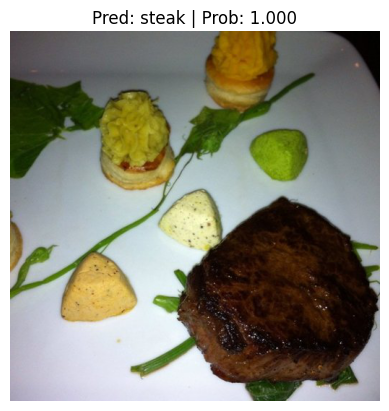

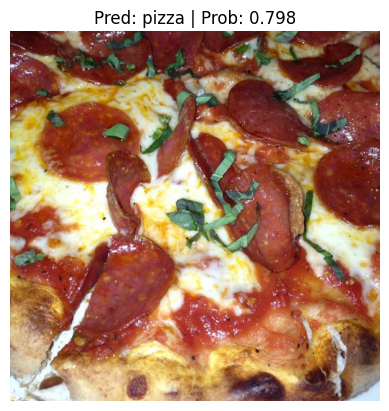

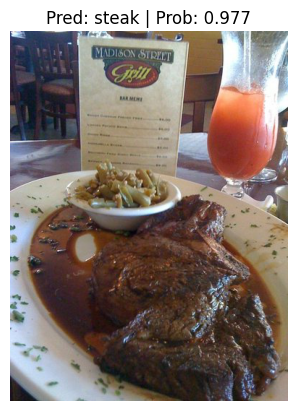

In [82]:
for image_path in test_image_path_sample:
    pred_and_plot_image(
        model=best_model,
        class_names=class_names,
        device=device,
        image_path=image_path,
        image_size=(224, 224)
    )

## 9.2 Predict on a Custom image with the best model.

In [84]:
import requests
from pathlib import Path

custom_image_path = Path("data/04-pizza-dad.jpeg")
image_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/data/04-pizza-dad.jpeg" 

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get(image_url)
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

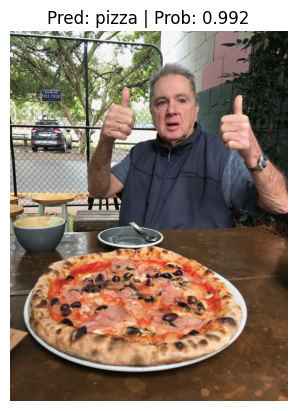

In [85]:
# predict on our custom image.
pred_and_plot_image(
    model=best_model,
    class_names=class_names,
    device=device,
    image_path=custom_image_path,
    image_size=(224, 224)
    )